In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.tail as exp_tail

plt.rcParams["mathtext.fontset"] = "cm"

# Outlier (level; pre-computed)

In [2]:
n = 500
dim = 1
res_stats_ol = pickle.load(open(f"../data/ol/stats_n{n}_d{dim}.pkl", "rb"))

ol_ls = list(res_stats_ol.keys())
eps_ls = list(res_stats_ol[ol_ls[0]].keys())

In [3]:
methods = {
    "standard": "IMQ-KSD", "tilted": "Tilted-KSD", "tilted_r_boot": "R-KSD",
    "dcmmd": "dcMMD", 
    "devmmd": "MMD-Dev",
    "tilted_r_boot_wild": "R-KSD-Wild"
}

def convert_df_ol(res_stats_ol):
    res_df = {"rej": [], "ol": [], "eps": [], "method": [], "theta": []}
    for i, ol in enumerate(ol_ls):
        rr = res_stats_ol[ol]
        
        for eps in eps_ls:
            rr = res_stats_ol[ol][eps]
            for method, lab in methods.items():
                if method in rr.keys():
                    rej = rr[method]["rej"]
                    res_df["rej"].extend(rej)
                    res_df["ol"].extend([ol] * len(rej))
                    res_df["eps"].extend([eps] * len(rej))
                    res_df["theta"].extend(rr["tilted_r_bootmax"]["theta"])
                    res_df["method"].extend([lab] * len(rej))

    res_df = pd.DataFrame(res_df)
    return res_df

In [4]:
res_df = convert_df_ol(res_stats_ol)

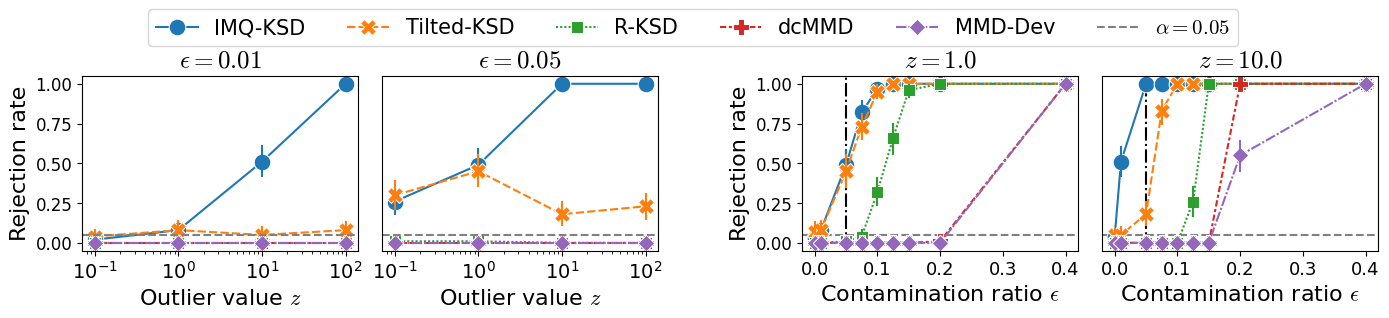

In [23]:
# level plot
eps_ls_plot = [0.01, 0.05]
fig = plt.figure(figsize=(3*4, 2.5))

# Define the width of each subplot and the gap you want between subplots 2 and 3
subplot_width = 0.23
gap = 0.1

# Define positions for each subplot
positions = [
    [0.05, 0.1, subplot_width, 0.7],              # subplot 1
    [0.3, 0.1, subplot_width, 0.7],               # subplot 2
    [0.55 + gap, 0.1, subplot_width, 0.7],        # subplot 3
    [0.8 + gap, 0.1, subplot_width, 0.7],         # subplot 4
]

# Create subplots with specific positions
ax1 = fig.add_axes(positions[0])
ax2 = fig.add_axes(positions[1])
ax3 = fig.add_axes(positions[2])
ax4 = fig.add_axes(positions[3])
axes = [ax1, ax2, ax3, ax4]
rej_ol
# level
for i, eps in enumerate(eps_ls_plot):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.eps == eps]
    
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

    ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis="both", labelsize=14)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel(r"Outlier value $z$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$\epsilon={eps}$", fontsize=18)
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

# power
eps0 = 0.05

eps_ls_plot = [0.1, 0.15, 0.2]
ol_ls_plot = [1., 10.]

for i, ol in enumerate(ol_ls_plot):
    ax = axes[i+2]
    res_df_sub = res_df.loc[(res_df.ol == ol) & (res_df.eps <= 0.5)]
    
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.axvline(eps0, linestyle="-.", color="k")
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis="both", labelsize=13)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$z={ol}$", fontsize=18)
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(.2, 1.11, 1, 0.2), loc="lower left", ncol=7, fontsize=15)
plt.savefig("../figs/robust/rej_ol.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

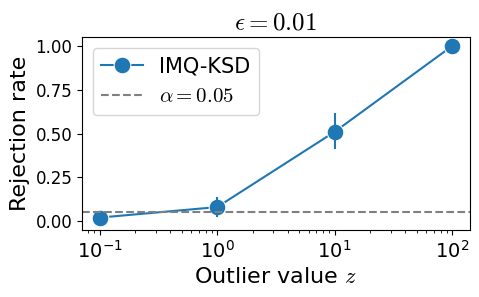

In [6]:
# for presentation
eps = 0.01

# level
_, ax = plt.subplots(figsize=(5, 2.5))
res_df_sub = res_df.loc[(res_df.eps == eps) & (res_df.method.isin(["IMQ-KSD"]))]

_ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis="both", labelsize=14)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel(r"Outlier value $z$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.set_title(rf"$\epsilon={eps}$", fontsize=18)
ax.legend([],[], frameon=False)

lgd = ax.legend(fontsize=15)
plt.savefig("../figs/robust/pre_rej_ol_imq.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")


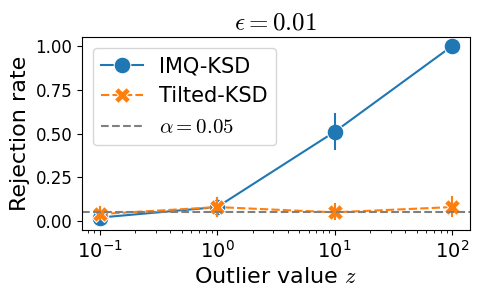

In [7]:
# for presentation
eps = 0.01

# level
_, ax = plt.subplots(figsize=(5, 2.5))
res_df_sub = res_df.loc[(res_df.eps == eps) & (res_df.method.isin(["IMQ-KSD", "Tilted-KSD"]))]

_ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis="both", labelsize=14)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel(r"Outlier value $z$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.set_title(rf"$\epsilon={eps}$", fontsize=18)
ax.legend([],[], frameon=False)

lgd = ax.legend(fontsize=15)
plt.savefig("../figs/robust/pre_rej_ol_tilted.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")


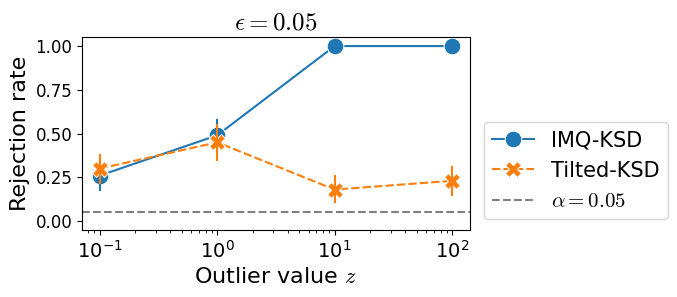

In [10]:
# for presentation
eps = 0.05

# level
_, ax = plt.subplots(figsize=(5, 2.5))
res_df_sub = res_df.loc[(res_df.eps == eps) & (res_df.method.isin(["IMQ-KSD", "Tilted-KSD"]))]

_ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis="both", labelsize=14)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel(r"Outlier value $z$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.set_title(rf"$\epsilon={eps}$", fontsize=18)
ax.legend([],[], frameon=False)

lgd = ax.legend(bbox_to_anchor=(1.01, 0., 1, 0.2), loc="lower left", fontsize=15)
plt.savefig("../figs/robust/pre_rej_ol_tilted_0.05.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")


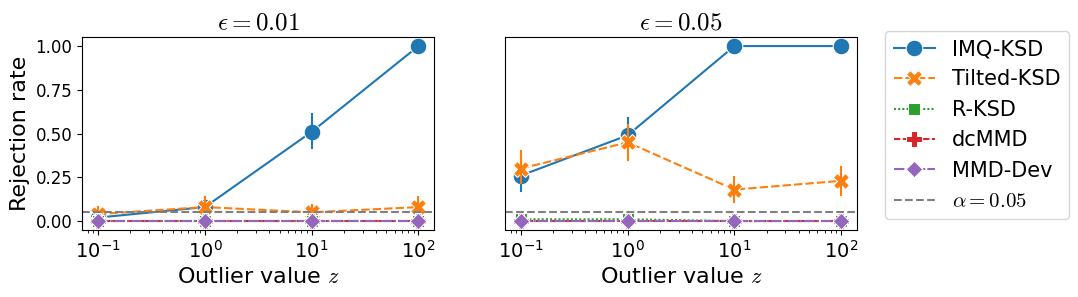

In [45]:
# for presentation
eps_ls_plot = [0.01, 0.05]

# level
for i, eps in enumerate(eps_ls_plot):
    _, ax = plt.subplots(figsize=(5, 2.5))
    res_df_sub = res_df.loc[(res_df.eps == eps) & (res_df.method.isin(["IMQ-KSD", ""]))]
    
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

    ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis="both", labelsize=14)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel(r"Outlier value $z$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$\epsilon={eps}$", fontsize=18)
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

    lgd = ax.legend(bbox_to_anchor=(1.05, 0., 1, 0.2), loc="lower left", fontsize=15)
    plt.savefig("../figs/robust/pre_rej_ol.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")
    # plt.savefig("../figs/robust/pre_rej_ol.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

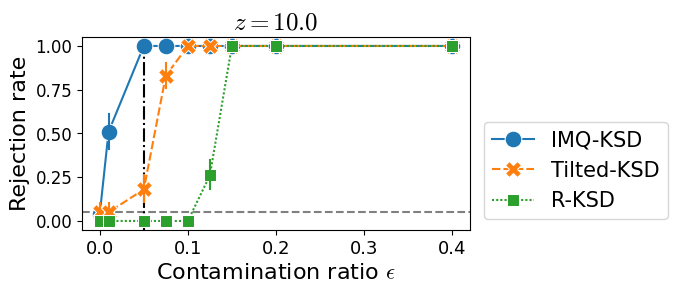

In [10]:
# for presentation

eps0 = 0.05

eps_ls_plot = [0.1, 0.15, 0.2]
ol_ls_plot = [10.]

for i, ol in enumerate(ol_ls_plot):
    _, ax = plt.subplots(figsize=(5, 2.5))
    res_df_sub = res_df.loc[(res_df.ol == ol) & (res_df.eps <= 0.5) & (res_df.method.isin(["IMQ-KSD", "Tilted-KSD", "R-KSD"]))]
    
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.axvline(eps0, linestyle="-.", color="k")
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)

    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis="both", labelsize=13)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$z={ol}$", fontsize=18)
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = ax.legend(bbox_to_anchor=(1.01, 0., 1, 0.2), loc="lower left", fontsize=15)
plt.savefig("../figs/robust/pre_rej_ol_power.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

/tmp/ipykernel_328508/3796469155.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


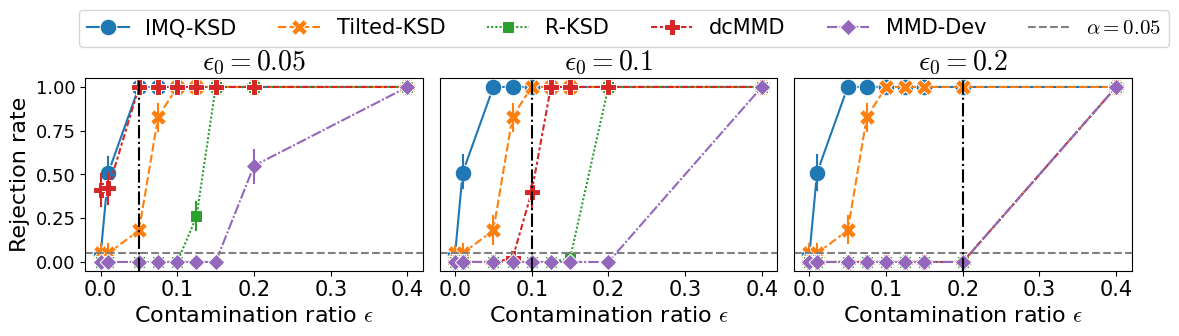

In [35]:
# level plot
eps0_ls_plot = [0.05, 0.1, 0.2]
ol_plot = 10.

fig, axes = plt.subplots(ncols=len(eps0_ls_plot), figsize=(4.5*len(eps0_ls_plot), 2.5))

for i, eps0 in enumerate(eps0_ls_plot):
    # change theta
    res_ol_new = copy.deepcopy(res_stats_ol)
    # res_new_wild = copy.deepcopy(res_stats_wild)
    for ol in ol_ls:
        for eps in eps_ls:
            tau = jnp.array(res_ol_new[ol][eps]["tilted_r_bootmax"]["tau"])
            theta_new = eps0 * tau**0.5
            
            res_ol_new[ol][eps] = exp_utils.change_theta(
                res_ol_new[ol][eps], ["tilted_r_boot", "tilted_r_dev", "dcmmd", "devmmd"], theta_new, eps0)
    
    res_df = convert_df_ol(res_ol_new)
    
    # plot
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.ol == ol_plot]
    
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
    ax.axvline(eps0, linestyle="-.", color="k")

    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis="both", labelsize=13)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$\epsilon_0={eps0}$", fontsize=20)
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(-0.05, 1.11, 1, 0.2), loc="lower left", ncol=7, fontsize=15)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig("../figs/robust/rej_ol_dev.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

# Mean-shift (power; pre-computed)

In [10]:
SAVE_DIR = "../data/ms"
n = 500
dim = 50

stats_res = pickle.load(open(f"{SAVE_DIR}/stats_n{n}_d{dim}.pkl", "rb"))

In [11]:
rr = stats_res

methods = {"standard": "IMQ-KSD", "tilted": "Tilted-KSD", "tilted_r_boot": "R-KSD"}

res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": [], "ms": []}
for method, lab in methods.items():
    for kk, ss in enumerate(mean_ls):
        rej = rr[ss][method]["rej"]
        res_df["rej"] = res_df["rej"] + rej
        res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
        res_df["method"] = res_df["method"] + [lab] * len(rej)
        mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
        res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
        res_df["ms"].extend([ss] * len(rej))
res_df = pd.DataFrame(res_df)

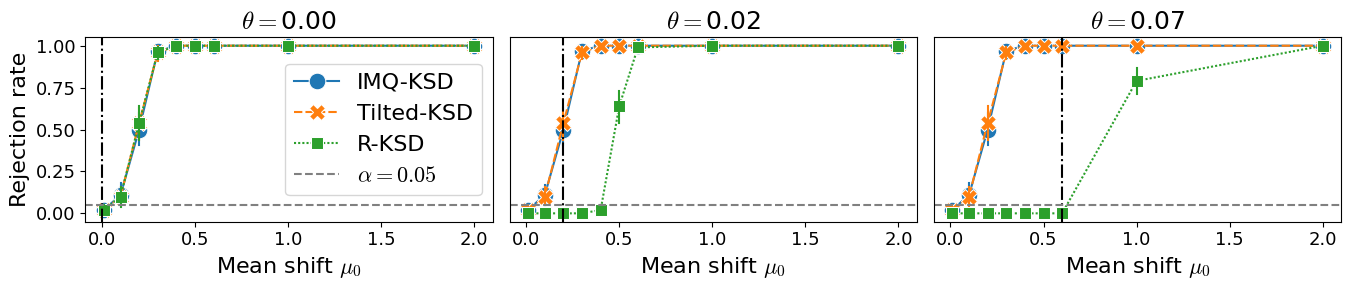

In [12]:
mean_ls = list(stats_res.keys())

theta_new_ls = [
    0.,
    res_df.loc[(res_df.method == "Tilted-KSD") & (res_df.mean_idx == 2), "ksd"].mean(),
    res_df.loc[(res_df.method == "Tilted-KSD") & (res_df.mean_idx == 6), "ksd"].mean(),
]
ms_thresh_ls = [0, mean_ls[2], mean_ls[6]]

_, axes = plt.subplots(ncols=len(theta_new_ls), figsize=(4.5*len(theta_new_ls), 3))

for i, theta_new in enumerate(theta_new_ls):
    # change theta
    stats_res_new = copy.deepcopy(stats_res)
    for ss in mean_ls:
        stats_res_new[ss] = exp_utils.change_theta(
            stats_res_new[ss], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)

    # plot
    rr = stats_res_new
    
    # methods = {"standard": "IMQ-KSD", "tilted": "Tilted-KSD", "tilted_r_boot": "R-KSD"}

    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": [], "ms": []}
    for method, lab in methods.items():
        for kk, ss in enumerate(mean_ls):
            rej = rr[ss][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
            res_df["ms"].extend([ss] * len(rej))
    res_df = pd.DataFrame(res_df)

    ax = axes[i]
    sns.lineplot(ax=ax, data=res_df, x="ms", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    
    theta = np.mean(rr[mean_ls[0]]["theta"])
    ax.axvline(ms_thresh_ls[i], linestyle="-.", color="k")
    ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha=0.05$")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel(r"Mean shift $\mu_0$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.set_title(r"$\theta=${:.2f}".format(round(theta, 2)), fontsize=18)
    ax.legend([],[], frameon=False)

    if i == 0:
        ax.legend(loc="center right", fontsize=16)
    else:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")
        
plt.tight_layout()
plt.savefig("../figs/robust/rej_ms.pdf")

In [24]:
# vs. dim
SAVE_DIR = "../data/ms"
n = 500
dim_ls = [1, 10, 50, 100]

stats_res_ls = {}
for dim in dim_ls:
    stats_res_ls[dim] = pickle.load(open(f"{SAVE_DIR}/stats_n{n}_d{dim}.pkl", "rb"))

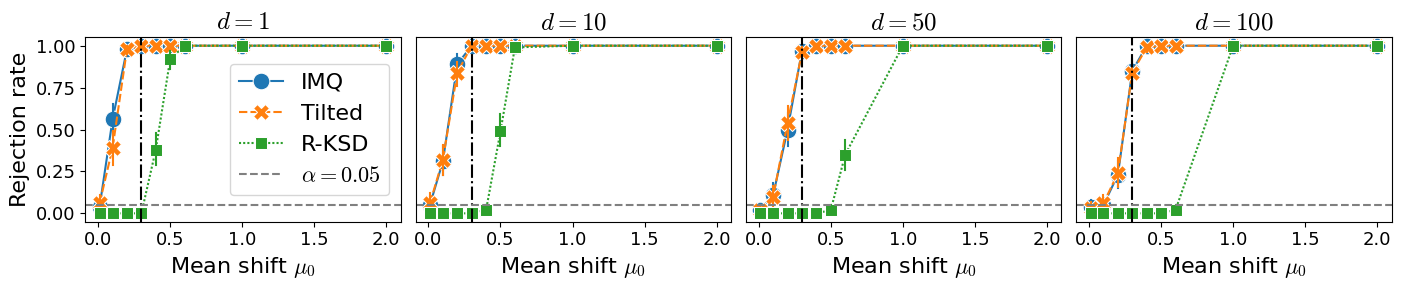

In [26]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(3.5*len(dim_ls), 3))

for i, dim in enumerate(dim_ls):
    
    rr = stats_res_ls[dim]
    mean_ls = list(rr.keys())

    # change theta
    ms_thresh = mean_ls[3]
    theta_new = np.mean(rr[ms_thresh]["tilted"]["u_stat"])**0.5
    stats_res_new = copy.deepcopy(rr)
    for ss in mean_ls:
        stats_res_new[ss] = exp_utils.change_theta(stats_res_new[ss], ["tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD"}
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": [], "ms": []}
    for method, lab in methods.items():
        for kk, ss in enumerate(mean_ls):
            rej = stats_res_new[ss][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
            res_df["ms"].extend([ss] * len(rej))
    res_df = pd.DataFrame(res_df)

    # plot
    ax = axes[i]
    sns.lineplot(ax=ax, data=res_df, x="ms", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    
    ax.axvline(ms_thresh, linestyle="-.", color="k")
    ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha=0.05$")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel(r"Mean shift $\mu_0$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.set_title(rf"$d = {dim}$", fontsize=18)
    ax.legend([],[], frameon=False)

    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

axes[0].legend(loc="center right", fontsize=16)
plt.tight_layout()
plt.savefig("../figs/robust/rej_ms_dim.pdf")

# Efron's vs. wild bootstrap

In [27]:
n = 500
dim = 1
res_stats = pickle.load(open(f"../data/ol/stats_n{n}_d{dim}.pkl", "rb"))
res_stats_wild = pickle.load(open(f"../data/ol/stats_wild_n{n}_d{dim}.pkl", "rb"))

ol_ls = list(res_stats.keys())
eps_ls = list(res_stats[ol_ls[0]].keys())

In [28]:
methods = {
    "standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD", "tilted_r_dev": "R-KSD-Dev", 
    "dcmmd": "dcMMD", 
    "devmmd": "MMD-Dev",
    "tilted_r_boot_wild": "R-KSD-Wild"
}

def convert_df_ol(res_stats_ol):
    res_df = {"rej": [], "ol": [], "eps": [], "method": [], "theta": []}
    for i, ol in enumerate(ol_ls):
        rr = res_stats_ol[ol]
        
        for eps in eps_ls:
            rr = res_stats_ol[ol][eps]
            for method, lab in methods.items():
                if method in rr.keys():
                    rej = rr[method]["rej"]
                    res_df["rej"].extend(rej)
                    res_df["ol"].extend([ol] * len(rej))
                    res_df["eps"].extend([eps] * len(rej))
                    res_df["theta"].extend(rr["tilted_r_bootmax"]["theta"])
                    res_df["method"].extend([lab] * len(rej))

    res_df = pd.DataFrame(res_df)
    return res_df

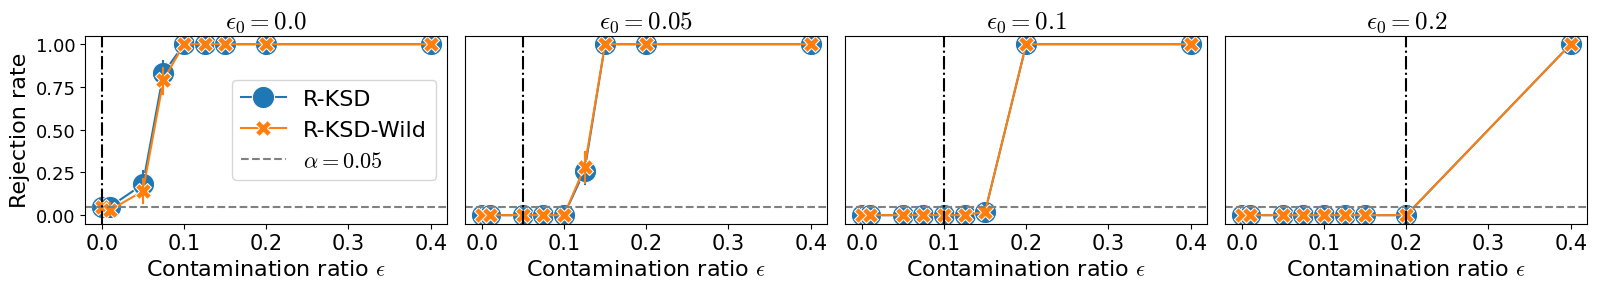

In [29]:
# level plot
eps0_ls_plot = [0., 0.05, 0.1, 0.2]
ol_plot = 10.

fig, axes = plt.subplots(ncols=len(eps0_ls_plot), figsize=(4*len(eps0_ls_plot), 3))

for i, eps0 in enumerate(eps0_ls_plot):
    # change theta
    res_new = copy.deepcopy(res_stats)
    res_new_wild = copy.deepcopy(res_stats_wild)
    for ol in ol_ls:
        for eps in eps_ls:
            tau = jnp.array(res_new[ol][eps]["tilted_r_bootmax"]["tau"])
            theta_new = eps0 * tau**0.5

            # Efron's bootstrap
            res_new[ol][eps] = exp_utils.change_theta(res_new[ol][eps], ["tilted_r_boot"], theta_new, eps0)

            # wild bootstrap
            res_new_wild[ol][eps] = exp_utils.change_theta(res_new_wild[ol][eps], ["tilted_r_boot"], theta_new, eps0)
            res_new[ol][eps]["tilted_r_boot_wild"] = res_new_wild[ol][eps]["tilted_r_boot"]

    res_df = convert_df_ol(res_new)
    
    # plot
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.ol == ol_plot]
    res_df_sub = res_df_sub.loc[(res_df_sub.method == "R-KSD") | (res_df_sub.method == "R-KSD-Wild")]
    
    _ = sns.lineplot(
        ax=ax, data=res_df_sub.loc[res_df_sub.method == "R-KSD"], 
        x="eps", y="rej", hue="method", style="method", markers=["o"], err_style="bars", markersize=16,
    )
    _ = sns.lineplot(
        ax=ax, data=res_df_sub.loc[res_df_sub.method == "R-KSD-Wild"], 
        x="eps", y="rej", style="method", markers=["X"], err_style="bars", markersize=12, color="C1",
    )
    ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")
    ax.axvline(eps0, linestyle="-.", color="k")

    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis="both", labelsize=13)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.set_xlabel(r"Contamination ratio $\epsilon$", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$\epsilon_0={eps0}$", fontsize=18)
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(loc="center right", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig("../figs/robust/rej_ol_wild.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

# Rate requirement

In [5]:
methods = {
    "tilted": "Tilted",
}

def convert_df_ol(res_stats_ol):
    res_df = {"rej": [], "eps": [], "method": []}

    ol = list(res_stats.keys())[0]
    eps_ls = list(res_stats[ol].keys())
    
    for eps in eps_ls:
        rr = res_stats_ol[ol][eps]
        for method, lab in methods.items():
            if method in rr.keys():
                rej = rr[method]["rej"]
                res_df["rej"].extend(rej)
                res_df["eps"].extend([eps] * len(rej))
                res_df["method"].extend([lab] * len(rej))

    res_df = pd.DataFrame(res_df)
    return res_df

In [12]:
dim = 1
s_ls = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6]
res_df_ls = []
for i, s in enumerate(s_ls):
    res_stats = pickle.load(open(f"../data/rate/stats_r{s}_d{dim}.pkl", "rb"))
    res_df = convert_df_ol(res_stats)
    res_df["r"] = -round(s-1, 2)

    res_df_ls.append(res_df)

res_df = pd.concat(res_df_ls, ignore_index=True)
ol = list(res_stats.keys())[0]
eps_ls = list(res_stats[ol].keys())

/tmp/ipykernel_697352/2903321474.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  _ = sns.lineplot(ax=ax, data=res_df.loc[res_df.r <= 0.5],


ERROR! Session/line number was not unique in database. History logging moved to new session 2


/tmp/ipykernel_697352/2903321474.py:9: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  _ = sns.lineplot(ax=ax, data=res_df.loc[res_df.r > 0.5],


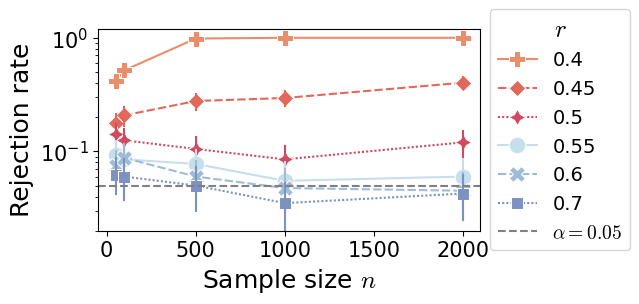

In [14]:
ol_plot = 10.
markers_ls = ["P", (4, 0, 0), (4, 1, 0)]

fig, ax = plt.subplots(figsize=(6.5, 3))

_ = sns.lineplot(ax=ax, data=res_df.loc[res_df.r <= 0.5], 
                 x="eps", y="rej", hue="r", style="r", markers=markers_ls, err_style="bars", markersize=12,
                 palette=sns.color_palette("flare"))
_ = sns.lineplot(ax=ax, data=res_df.loc[res_df.r > 0.5], 
                 x="eps", y="rej", hue="r", style="r", markers=True, err_style="bars", markersize=12,
                 palette=sns.color_palette("ch:s=.25,rot=-.25"))
ax.axhline(0.05, linestyle="--", color="grey", label=r"$\alpha = 0.05$")

ax.set_ylim(2e-2, 1.2)
ax.set_yscale("log")
# ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis="both", labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.set_xlabel(r"Sample size $n$", fontsize=18)
ax.set_ylabel("Rejection rate", fontsize=18)
ax.legend([],[], frameon=False)

lgd = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
lgd.set_title(r"$r$", prop={"size": 18})
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig("../figs/robust/rej_ol_rate.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

# Front page figure

In [7]:
dim = 1
n = 500
ol = 10.
eps_ls = [0., 0.05]

res_stats= pickle.load(open(f"../data/ol/ol_stats_n{n}_d1.pkl", "rb"))

Xs_ls = []
val_ls_imq = []
val_ls_tilted = []
rej_ls_imq = []
rej_ls_tilted = []
rej_ls_boot = []
rej_ls_bootmax = []
for eps in eps_ls:
    res = res_stats[ol][eps]
    
    rej_ls_imq.append(res["standard"]["rej"])
    rej_ls_tilted.append(res["tilted"]["rej"])
    rej_ls_boot.append(res["tilted_r_boot"]["rej"])
    rej_ls_bootmax.append(res["tilted_r_bootmax"]["rej"])

    val_ls_imq.append(res["standard"]["nonsq_stat"])
    val_ls_tilted.append(res["tilted"]["nonsq_stat"])

nreps = len(res["standard"]["rej"])

In [8]:
X_res = pickle.load(open(f"../data/ol/ol_X_res_n{n}_d1.pkl", "rb"))
Xs_ls = [X_res[ol][eps_ls[0]], X_res[ol][eps_ls[1]]]

In [ ]:
from pylab import setp
import matplotlib


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    c1, c2 = "C0", "C1"
    setp(bp['boxes'][0], color=c1, linewidth=2)
    setp(bp['caps'][0], color=c1, linewidth=2)
    setp(bp['caps'][1], color=c1, linewidth=2)
    setp(bp['whiskers'][0], color=c1, linewidth=2)
    setp(bp['whiskers'][1], color=c1, linewidth=2)
    # setp(bp['fliers'][0], color=c1)
    # setp(bp['fliers'][1], color=c1)
    setp(bp['medians'][0], color=c1, linewidth=2)

    setp(bp['boxes'][1], color=c2, linewidth=2)
    setp(bp['caps'][2], color=c2, linewidth=2)
    setp(bp['caps'][3], color=c2, linewidth=2)
    setp(bp['whiskers'][2], color=c2, linewidth=2)
    setp(bp['whiskers'][3], color=c2, linewidth=2)
    setp(bp['medians'][1], color=c2, linewidth=2)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

# bins = np.histogram(np.hstack(
#     (Xs_ls[0][0].reshape(-1), Xs_ls[1].reshape(-1))
# ), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# hist plots
ax = axes[0]
_, bins, patches = ax.hist(Xs_ls[1][0].reshape(-1), bins, color="grey", density=True, linewidth=1.5)
patches[-1].set(edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(Xs_ls[0][0].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# boxplots
ax = axes[1]
df = pd.DataFrame({
    "rej": np.concatenate(rej_ls_imq + rej_ls_tilted + rej_ls_boot + rej_ls_bootmax, 0).tolist(),
    "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2 + ["R-KSD-Boot"] * nreps * 2 + ["R-KSD-BootMax"] * nreps * 2,
    "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
})
b = sns.barplot(data=df, x="method", y="rej", hue="Outlier", errorbar=None)
h3 = ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0, 1.1)
ax.set_xlabel("")
plt.xticks(fontsize=10)
ax.set_ylabel("Rejection probability", fontsize=13)
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in b.get_xticklabels())]
ax.legend(handles=patches[:2]+[h3], labels=["Without outliers", "With outliers", r"$\alpha=0.05$"])
for container in b.containers:
    b.bar_label(container)

plt.tight_layout()
# plt.savefig("../figs/robust/thumbnail.pdf")

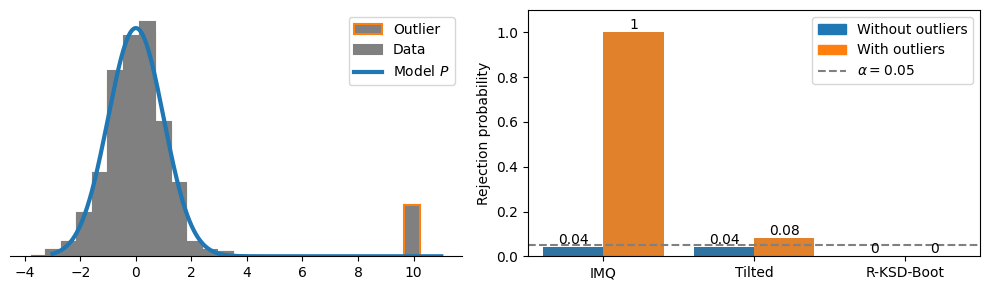

In [98]:
from pylab import setp
import matplotlib


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    c1, c2 = "C0", "C1"
    setp(bp['boxes'][0], color=c1, linewidth=2)
    setp(bp['caps'][0], color=c1, linewidth=2)
    setp(bp['caps'][1], color=c1, linewidth=2)
    setp(bp['whiskers'][0], color=c1, linewidth=2)
    setp(bp['whiskers'][1], color=c1, linewidth=2)
    # setp(bp['fliers'][0], color=c1)
    # setp(bp['fliers'][1], color=c1)
    setp(bp['medians'][0], color=c1, linewidth=2)

    setp(bp['boxes'][1], color=c2, linewidth=2)
    setp(bp['caps'][2], color=c2, linewidth=2)
    setp(bp['caps'][3], color=c2, linewidth=2)
    setp(bp['whiskers'][2], color=c2, linewidth=2)
    setp(bp['whiskers'][3], color=c2, linewidth=2)
    setp(bp['medians'][1], color=c2, linewidth=2)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

bins = np.histogram(np.hstack(
    (Xs_ls[0][0].reshape(-1), Xs_ls[1].reshape(-1))
), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# hist plots
ax = axes[0]
ax.hist(Xs_ls[1][0].reshape(-1), bins, color="grey", density=True, edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(Xs_ls[0][0].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# boxplots
ax = axes[1]
# df = pd.DataFrame({
#     "rej": (np.concatenate(pval_ls_imq + pval_ls_tilted, 0) < 0.05).tolist(),
#     "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2,
#     "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
# })
df = pd.DataFrame({
    "rej": (np.concatenate(pval_ls_imq + pval_ls_tilted + pval_ls_boot, 0) < 0.05).tolist(),
    "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2 + ["R-KSD-Boot"] * nreps * 2,
    "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
})
b = sns.barplot(data=df, x="method", y="rej", hue="Outlier", errorbar=None)
h3 = ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0, 1.1)
ax.set_xlabel("")
ax.set_ylabel("Rejection probability")
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in b.get_xticklabels())]
ax.legend(handles=patches[:2]+[h3], labels=["Without outliers", "With outliers", r"$\alpha=0.05$"])
for container in b.containers:
    b.bar_label(container)

plt.tight_layout()
# plt.savefig("../figs/robust/thumbnail.pdf")

\begin{tabular}{lrr}
\toprule
 & IMQ & Tilted \\
\midrule
Without & 0.6 & 0.47 \\
With & 0.045 & 0.47 \\
\bottomrule
\end{tabular}



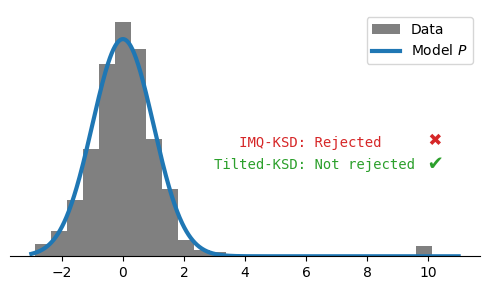

In [8]:
_, ax = plt.subplots(figsize=(5, 3))

bins = np.histogram(np.hstack(
    (X_ls[0].reshape(-1), X_ls[1].reshape(-1))
), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

t_ls = [
    "   IMQ-KSD: ",
    "Tilted-KSD: "
]
checks_ls = []
outlier_pvals = [pval_ls_imq[1], pval_ls_boot[1]]
for i, pval in enumerate(outlier_pvals):
    suffix = "Rejected" if pval < 0.05 else "Not rejected"
    t_ls[i] += suffix
    checks_ls.append("\u2716" if pval < 0.05 else "\u2714")

pvals_df = pd.DataFrame({"IMQ": pval_ls_imq, "Tilted": pval_ls_tilted}, index=["Without", "With"])

ax.hist(X_ls[1].reshape(-1), bins, color="grey", density=True)
ax.hist(X_ls[0].reshape(-1), bins, color="grey", density=True, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$")

ax.text(3., .2, t_ls[0], fontname="monospace", color="C3")
ax.text(3., .16, t_ls[1], fontname="monospace", color="C2")

ax.text(10., .2, checks_ls[0], fontname="monospace", color="C3", fontsize=16)
ax.text(10., .16, checks_ls[1], fontname="monospace", color="C2", fontsize=16)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

plt.tight_layout()
# plt.savefig("../figs/robust/front_fig.pdf")

print(pvals_df.to_latex(float_format="{:.2g}".format,))

In [72]:
# var decomp of v stats
def sum_coeffs(n):
    return n*(n-1)*(n-2)*(n-3) + 2*n*(n-1)*(n-2) + 4*n*(n-1)*(n-2) + n*(n-1) + 2*n*(n-1) + 4*n*(n-1) + n

In [74]:
nn = 4
sum_coeffs(nn), nn**4

(256, 256)

# Slides

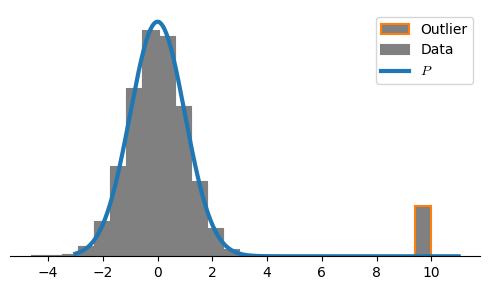

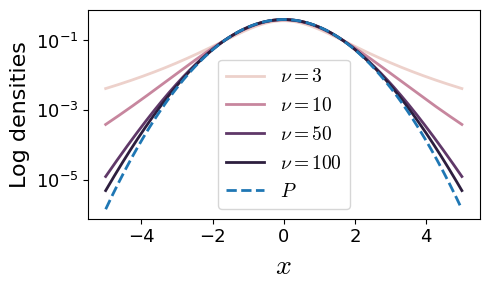

In [19]:
dim = 1
n = 500
ol = 10.
eps = 0.05

X_res = pickle.load(open(f"../data/ol/X_res_n{n}_d1.pkl", "rb"))
Xs = X_res[ol][eps]

xvals = jnp.linspace(-3., ol+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

# _, ax = plt.subplots(figsize=(5, 3))
# hist plots
ax = axes[0]
bins = np.histogram(np.hstack(
    (Xs.reshape(-1), Xs[Xs < 8.].reshape(-1))
), bins=25)[1]

ax.hist(Xs.reshape(-1), bins, color="grey", density=True, edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(Xs[Xs < 6.].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"$P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# plt.tight_layout()
# plt.savefig("../figs/robust/pre_ol.pdf")

# _, ax = plt.subplots(figsize=(5, 3))
# t densities
ax = axes[1]

x_plot = jnp.linspace(-5., 5., 1001)
model_pdf = jax.scipy.stats.norm.pdf(x_plot)

den_df = {"x": [], "den": [], "dof": []}
for dof in [3, 10, 50, 100]:
    data_pdf = exp_tail.t_pdf_multivariate(x_plot.reshape((-1, 1)), df=dof).tolist()
    den_df["x"].extend(x_plot.tolist())
    den_df["den"].extend(data_pdf)
    den_df["dof"].extend([dof] * len(x_plot))
den_df = pd.DataFrame(den_df)

g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue=np.log(den_df.dof), legend="full", linewidth=2)
g2 = ax.plot(x_plot, model_pdf, color="C0", linestyle="--", label="Model", linewidth=2)
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel("Log densities", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=13)
ax.legend(handles=g1.get_legend().legend_handles + g2, labels=[rf"$\nu={r}$" for r in den_df.dof.unique().tolist()] + ["$P$"], fontsize=14)

# plt.tight_layout()
# plt.savefig("../figs/robust/pre_tail.pdf")

plt.tight_layout()
plt.savefig("../figs/robust/pre_ol_tail.pdf")

#### Stein kernel

In [20]:
X = jnp.reshape(jnp.linspace(-3., 3., 1001), (-1, 1))

b_ls = [0., 0.25, 0.5, 1.]
ksd_vals_ls = []

score_fn = lambda x: -x

# IMQ
kernel = kernels.IMQ(sigma_sq=2*1.)
ksd_imq = metrics.KSD(kernel, score_fn=score_fn)

ksd_imq_vals = np.diagonal(ksd_imq(X, X, vstat=True, output_dim=2))
ksd_vals_ls.append(ksd_imq_vals)

# R-KSD boot
score = score_fn(X)

for b in b_ls[1:]:
    score_weight_fn = kernels.PolyWeightFunction(b=b)
    kernel0 = kernels.IMQ(sigma_sq=2*1.)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    ksd_tilted = metrics.KSD(kernel)
    
    ksd_tilted_vals = np.diagonal(ksd_tilted(X, X, vstat=True, output_dim=2, score=score))
    ksd_vals_ls.append(ksd_tilted_vals)

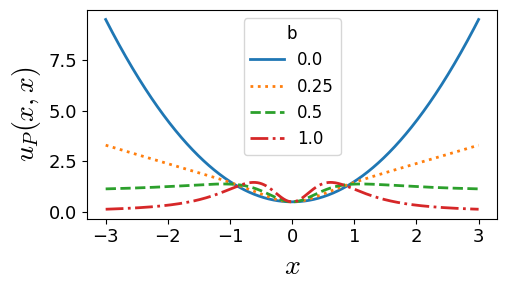

In [31]:
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True

_, ax = plt.subplots(figsize=(5, 3))
linestyles = ["solid", "dotted", "dashed", "dashdot"]

for i, b in enumerate(b_ls):
    ksd_vals = ksd_vals_ls[i]
    ax.plot(np.reshape(X, -1), ksd_vals, label=f"{b}", linestyle=linestyles[i], lw=2)
    # ax.plot(np.reshape(X, -1), ksd_vals, label=f"{b}")
# ax.set_yscale("log")
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$u_P(x, x)$", fontsize=20)
ax.tick_params(axis="both", labelsize=13)
ax.legend(title="b", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.savefig("../figs/robust/pre_stein_kernels.pdf")